# COVID county travel impact

Beginning in March 2020, we saw widespread lockdowns and fear of public interactions that had a large-scale impact on trip activity. The goal of this report is to measure that impact by county as a function of population density and the lengths of trips taken.

## [Data Processing](#Data)

## [Defining Variables to Study](#Define-variables-to-study)

## [Hypothesis #1](#Hypothesis-1)

## [Hypothesis #2](#Hypothesis-2)

## [Extra Thoughts](#Some-Extra-Thoughts)

## Data

Sources:
* BTS Trips by Distance
* Census 2010 Percent Urban and Rural by County (PctUrbanRural_County)
* Census 2019 Population/Demographics Estimates (cc_est2019)

Data from BTS was aggregated by month and county and exported as CSV to be imported in pandas. The structure of the data is described by the following SQL query:

In [1]:
"""
SELECT
    DATE_TRUNC('month', date) AS date,
    county_fips,
    AVERAGE(population_staying_at_home) AS pop_staying_at_home,
    AVERAGE(population_not_staying_at_home) AS pop_not_staying_at_home,
    SUM(number_of_trips) AS number_of_trips,
    SUM(number_of_trips_less_than_1) AS number_of_trips_less_than_1,
    .
    .
    .
FROM BTS.TRIPS_BY_DISTANCE
WHERE level = 'County'
GROUP BY date, county_fips
ORDER BY date, county_fips
""";

#### Imports

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import math

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

pd.options.display.max_columns = None
pd.options.display.max_rows = None

%matplotlib inline
plt.rcParams.update({'font.size': 16})

# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Functions

In [3]:
def fix_fips(fips):
    if len(fips) == 4:
        return '0' + fips
    elif len(fips) == 3:
        return '00' + fips
    else:
        return fips
    
def fix_state_fips(state):
    if len(state) == 1:
        return '0' + state
    else:
        return state
    
def fix_county_fips(county):
    if len(county) == 1:
        return '00' + county
    elif len(county) == 2:
        return '0' + county
    else:
        return county

#### Trips Data

In [4]:
trips_df = pd.read_csv('Trips_by_Distance.csv', dtype={'County FIPS': str})

In [5]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81718 entries, 0 to 81717
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            81718 non-null  object 
 1   County FIPS                     81692 non-null  object 
 2   Population Staying at Home      81371 non-null  float64
 3   Population Not Staying at Home  81371 non-null  float64
 4   Number of Trips                 81371 non-null  float64
 5   Number of Trips <1              81371 non-null  float64
 6   Number of Trips 1-3             81371 non-null  float64
 7   Number of Trips 3-5             81371 non-null  float64
 8   Number of Trips 5-10            81371 non-null  float64
 9   Number of Trips 10-25           81371 non-null  float64
 10  Number of Trips 25-50           81371 non-null  float64
 11  Number of Trips 50-100          81371 non-null  float64
 12  Number of Trips 100-250         

In [6]:
### Counties with no trip data are too small to measure and should be excluded
trips_df = trips_df.dropna(subset=['Number of Trips'])

In [7]:
trips_df['County FIPS'] = trips_df['County FIPS'].astype(str)
trips_df.loc[:, 'County FIPS'] = trips_df.loc[:, 'County FIPS'].apply(fix_fips)

In [8]:
trips_df['Date'] = pd.to_datetime(trips_df['Date'])

In [9]:
trips_df['Month'] = trips_df['Date'].dt.month.astype(str)
trips_df['Year'] = trips_df['Date'].dt.year.astype(str)

In [10]:
def fix_month(month):
    if len(month) == 1:
        return '0' + month
    else:
        return month

In [11]:
trips_df.loc[:, 'Month'] = trips_df.loc[:, 'Month'].apply(fix_month)

In [12]:
trips_df['Year_Month'] = trips_df['Year'].astype(str) + '_' + trips_df['Month'].astype(str)

In [13]:
trips_df = trips_df[['Year_Month', 'County FIPS', 'Population Staying at Home',
       'Population Not Staying at Home', 'Number of Trips',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips >=500', 'Date']]

In [14]:
trips_df = trips_df.sort_values(['Date', 'County FIPS'])

#### Census Estimates

In [15]:
cc_df = pd.read_csv('cc-est2019-alldata.csv', encoding='latin-1')

In [16]:
### Only interested in 2019 data
cc_df = cc_df[cc_df['YEAR'] == 12]

In [17]:
def age_buckets(agegrp):
    if agegrp == 0:
        return 'Total Population'
    elif agegrp <= 3:
        ### Ages 0 - 14
        return 'Minor Population'
    elif agegrp <= 12:
        ### Ages 15 - 59 (non-seniors who can drive)
        return 'Adult Population'
    else:
        ### Ages 60+ (most likely to be impacted by COVID)
        return 'Senior Population'

In [18]:
cc_df.loc[:, 'Age Bucket'] = cc_df.loc[:, 'AGEGRP'].apply(age_buckets)

In [19]:
cc_df = cc_df.astype({'STATE': str, 'COUNTY': str})
cc_df.loc[:, 'STATE'] = cc_df.loc[:, 'STATE'].apply(fix_state_fips)
cc_df.loc[:, 'COUNTY'] = cc_df.loc[:, 'COUNTY'].apply(fix_county_fips)
cc_df['County FIPS'] = cc_df['STATE'] + cc_df['COUNTY']

In [20]:
cc_df = cc_df.groupby(['County FIPS', 'Age Bucket'])['TOT_POP'].sum().unstack('Age Bucket').reset_index()

In [21]:
### Not a whole lot of variance in Senior population percentage (although one county has 66% seniors)
(cc_df['Senior Population'] / cc_df['Total Population']).describe()

count    3142.000000
mean        0.268374
std         0.058449
min         0.070872
25%         0.230864
50%         0.264844
75%         0.300359
max         0.666266
dtype: float64

In [22]:
cc_df.head()

Age Bucket County FIPS  Adult Population  Minor Population  Senior Population  \
0                01001             32982             10593              12294   
1                01003            121072             39184              62978   
2                01005             14092              4193               6401   
3                01007             13558              3713               5123   
4                01009             32417             10935              14474   

Age Bucket  Total Population  
0                      55869  
1                     223234  
2                      24686  
3                      22394  
4                      57826

In [23]:
trips_df = trips_df.merge(cc_df, on='County FIPS', how='left')

#### Urban/Rural

In [24]:
urban_rural_df = pd.read_excel('PctUrbanRural_County.xls')

In [25]:
urban_rural_df.head()

STATE  COUNTY STATENAME COUNTYNAME  POP_COU    AREA_COU  POP_URBAN  \
0      1       1   Alabama    Autauga    54571  1539582278      31650   
1      1       3   Alabama    Baldwin   182265  4117521611     105205   
2      1       5   Alabama    Barbour    27457  2291818968       8844   
3      1       7   Alabama       Bibb    22915  1612480789       7252   
4      1       9   Alabama     Blount    57322  1669961855       5760   

   POPPCT_URBAN  AREA_URBAN  AREAPCT_URBAN  POPDEN_URBAN  POP_UA  POPPCT_UA  \
0         58.00    50882539           3.30        1611.0   31650      58.00   
1         57.72   275001368           6.68         990.8   63649      34.92   
2         32.21    17447656           0.76        1312.8       0       0.00   
3         31.65    18903236           1.17         993.6       0       0.00   
4         10.05    10874700           0.65        1371.8     386       0.67   

     AREA_UA  AREAPCT_UA  POPDEN_UA  POP_UC  POPPCT_UC    AREA_UC  AREAPCT_UC  \
0   50882539        3.30     1611.0       0       0.00          0        0.00   
1  163619520        3.97     1007.5   41556      22.80  111381848        2.71   
2          0        0.00        NaN    8844      32.21   17447656        0.76   
3          0        0.00        NaN    7252      31.65   18903236        1.17   
4    1022979        0.06      977.3    5374       9.38    9851721        0.59   

   POPDEN_UC  POP_RURAL  POPPCT_RURAL  AREA_RURAL  AREAPCT_RURAL  POPDEN_RURAL  
0        NaN      22921         42.00  1488699739          96.70          39.9  
1      966.3      77060         42.28  3842520243          93.32          51.9  
2     1312.8      18613         67.79  2274371312          99.24          21.2  
3      993.6      15663         68.35  1593577553          98.83          25.5  
4     1412.8      51562         89.95  1659087155          99.35          80.5

In [26]:
urban_rural_df = urban_rural_df.astype({'STATE': str, 'COUNTY': str})
urban_rural_df.loc[:, 'STATE'] = urban_rural_df.loc[:, 'STATE'].apply(fix_state_fips)
urban_rural_df.loc[:, 'COUNTY'] = urban_rural_df.loc[:, 'COUNTY'].apply(fix_county_fips)
urban_rural_df['County FIPS'] = urban_rural_df['STATE'] + urban_rural_df['COUNTY']

In [27]:
urban_rural_df['PCT_URBAN'] = urban_rural_df['POP_URBAN'] / urban_rural_df['POP_COU']
urban_rural_df['PCT_RURAL'] = urban_rural_df['POP_RURAL'] / urban_rural_df['POP_COU']
urban_rural_df = urban_rural_df[['STATENAME', 'COUNTYNAME', 'County FIPS', 'PCT_URBAN', 'PCT_RURAL']]

In [28]:
### Quartiles to describe how urban/rural a county is
urban_rural_df['URBAN_RURAL'] = pd.qcut(urban_rural_df['PCT_URBAN'], q=4, labels=['Very Rural', 'Rural', 'Suburban', 'Very Urban'], duplicates='drop')

In [29]:
urban_rural_df.head()

STATENAME COUNTYNAME County FIPS  PCT_URBAN  PCT_RURAL URBAN_RURAL
0   Alabama    Autauga       01001   0.579978   0.420022    Suburban
1   Alabama    Baldwin       01003   0.577209   0.422791    Suburban
2   Alabama    Barbour       01005   0.322104   0.677896       Rural
3   Alabama       Bibb       01007   0.316474   0.683526       Rural
4   Alabama     Blount       01009   0.100485   0.899515  Very Rural

In [30]:
trips_df = trips_df.merge(urban_rural_df, on='County FIPS', how='left')

In [31]:
trips_df[trips_df['PCT_URBAN'].isna()]['County FIPS'].nunique()

3

In [32]:
### Two counties with no census data - drop
trips_df = trips_df.dropna(subset=['PCT_URBAN'])

#### Define variables to study

In [33]:
### Two counties with no census data - drop
trips_df = trips_df.dropna(subset=['PCT_URBAN'])

In [34]:
### Defining March 1st and later as Post-COVID
trips_df['Post_COVID'] = (trips_df['Date'] >= pd.to_datetime('2020-04-01')).astype(int)

In [35]:
### Trips per Capita - Avg number of trips a resident of a county takes per month
trips_df['Trips per Capita'] = trips_df['Number of Trips'] / trips_df['Total Population']

In [36]:
### Avg percentage of population staying at home during a month
trips_df['Percent of Population Not Staying at Home'] = trips_df['Population Not Staying at Home'] / (trips_df[['Population Not Staying at Home', 'Population Staying at Home']].sum(axis=1))

In [37]:
### Pct of trips under certain distance
pct_trip_cols = []

for col in ['Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5', 'Number of Trips 5-10', 
            'Number of Trips 10-25', 'Number of Trips 25-50', 'Number of Trips 50-100', 'Number of Trips 100-250', 
            'Number of Trips 250-500', 'Number of Trips >=500']:
    col_name = 'Percent' + col[6:]
    pct_trip_cols.append(col_name)
    trips_df[col_name] = trips_df[col] / trips_df['Number of Trips']

In [38]:
### Buckets of Trip Lengths - Short, Med, Long
short_trips = ['Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5']
med_trips = ['Number of Trips 5-10', 'Number of Trips 10-25', 'Number of Trips 25-50']
long_trips = ['Number of Trips 50-100', 'Number of Trips 100-250', 'Number of Trips 250-500', 'Number of Trips >=500']

In [39]:
trips_df['Percent of Short Trips'] = trips_df[short_trips].sum(axis=1) / trips_df['Number of Trips']
trips_df['Short Trips per Capita'] = trips_df[short_trips].sum(axis=1) / trips_df['Total Population']

trips_df['Percent of Med Trips'] = trips_df[med_trips].sum(axis=1) / trips_df['Number of Trips']
trips_df['Med Trips per Capita'] = trips_df[med_trips].sum(axis=1) / trips_df['Total Population']

trips_df['Percent of Long Trips'] = trips_df[long_trips].sum(axis=1) / trips_df['Number of Trips']
trips_df['Long Trips per Capita'] = trips_df[long_trips].sum(axis=1) / trips_df['Total Population']

In [40]:
trips_df['Percent Short and Med'] = trips_df['Percent of Short Trips'] + trips_df['Percent of Med Trips']
trips_df['Percent Short Med Long'] = trips_df['Percent of Short Trips'] + trips_df['Percent of Med Trips'] + trips_df['Percent of Long Trips']

In [41]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81293 entries, 1 to 81370
Data columns (total 46 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Year_Month                                 81293 non-null  object        
 1   County FIPS                                81293 non-null  object        
 2   Population Staying at Home                 81293 non-null  float64       
 3   Population Not Staying at Home             81293 non-null  float64       
 4   Number of Trips                            81293 non-null  float64       
 5   Number of Trips <1                         81293 non-null  float64       
 6   Number of Trips 1-3                        81293 non-null  float64       
 7   Number of Trips 3-5                        81293 non-null  float64       
 8   Number of Trips 5-10                       81293 non-null  float64       
 9   Number of Trips 1

In [42]:
trips_df.head()

Year_Month County FIPS  Population Staying at Home  \
1    2019_01       01001                    252767.0   
2    2019_01       01003                   1099412.0   
3    2019_01       01005                    116141.0   
4    2019_01       01007                     88618.0   
5    2019_01       01009                    237149.0   

   Population Not Staying at Home  Number of Trips  Number of Trips <1  \
1                       1465594.0        5747603.0           1235692.0   
2                       5638624.0       21143457.0           4119496.0   
3                        652814.0        2652215.0            540849.0   
4                        603674.0        2433003.0            491023.0   
5                       1550404.0        5980579.0           1099126.0   

   Number of Trips 1-3  Number of Trips 3-5  Number of Trips 5-10  \
1            1412907.0             784389.0              809125.0   
2            5314232.0            2890715.0             3716202.0   
3             590786.0             386345.0              472760.0   
4             613117.0             295826.0              360211.0   
5            1197112.0             735596.0              955666.0   

   Number of Trips 10-25  Number of Trips 25-50  Number of Trips 50-100  \
1              1088048.0               253979.0                 98505.0   
2              3532992.0              1130092.0                250847.0   
3               359482.0               180842.0                 93098.0   
4               317353.0               268994.0                 59843.0   
5              1096334.0               673120.0                153812.0   

   Number of Trips 100-250  Number of Trips 250-500  Number of Trips >=500  \
1                  53474.0                   9834.0                 1650.0   
2                 117698.0                  54636.0                16547.0   
3                  21691.0                   5468.0                  894.0   
4                  20214.0                   5578.0                  844.0   
5                  53787.0                  13756.0                 2270.0   

        Date  Adult Population  Minor Population  Senior Population  \
1 2019-01-01           32982.0           10593.0            12294.0   
2 2019-01-01          121072.0           39184.0            62978.0   
3 2019-01-01           14092.0            4193.0             6401.0   
4 2019-01-01           13558.0            3713.0             5123.0   
5 2019-01-01           32417.0           10935.0            14474.0   

   Total Population STATENAME COUNTYNAME  PCT_URBAN  PCT_RURAL URBAN_RURAL  \
1           55869.0   Alabama    Autauga   0.579978   0.420022    Suburban   
2          223234.0   Alabama    Baldwin   0.577209   0.422791    Suburban   
3           24686.0   Alabama    Barbour   0.322104   0.677896       Rural   
4           22394.0   Alabama       Bibb   0.316474   0.683526       Rural   
5           57826.0   Alabama     Blount   0.100485   0.899515  Very Rural   

   Post_COVID  Trips per Capita  Percent of Population Not Staying at Home  \
1           0        102.876425                                   0.852902   
2           0         94.714322                                   0.836835   
3           0        107.438022                                   0.848963   
4           0        108.645307                                   0.871993   
5           0        103.423702                                   0.867333   

   Percent of Trips <1  Percent of Trips 1-3  Percent of Trips 3-5  \
1             0.214993              0.245825              0.136472   
2             0.194835              0.251342              0.136719   
3             0.203924              0.222752              0.145669   
4             0.201818              0.252000              0.121589   
5             0.183783              0.200167              0.122997   

   Percent of Trips 5-10  Percent of Trips 10-25  Percent of Trips 25-50  \
1               0.14077

In [43]:
trips_df_copy = trips_df.copy()
trips_df = trips_df[(trips_df['Date'] >= pd.to_datetime('2020-01-01')) & (trips_df['Date'] <= pd.to_datetime('2020-06-01'))]

In [44]:
trip_diff_df = trips_df.groupby(['County FIPS', 
                                 'Post_COVID'])[['Trips per Capita']].mean().unstack('Post_COVID').reset_index()
trip_diff_df['Post_COVID_Diff'] = trip_diff_df[('Trips per Capita', 1)] - trip_diff_df[('Trips per Capita', 0)]
trip_diff_df['Post_COVID_Pct_Diff'] = trip_diff_df['Post_COVID_Diff'] / trip_diff_df[('Trips per Capita', 0)]
trip_diff_df.columns = ['County FIPS', 'Pre COVID Trips per Capita', 'Post COVID Trips per Capita', 
                        'Post COVID Diff', 'Post COVID Pct Diff']

In [45]:
trip_diff_df.head()

County FIPS  Pre COVID Trips per Capita  Post COVID Trips per Capita  \
0       01001                  100.901168                    92.455989   
1       01003                   90.927916                    81.678975   
2       01005                  105.707175                   101.443963   
3       01007                  108.893424                   101.800140   
4       01009                  102.161335                    97.741783   

   Post COVID Diff  Post COVID Pct Diff  
0        -8.445178            -0.083698  
1        -9.248941            -0.101717  
2        -4.263213            -0.040330  
3        -7.093284            -0.065140  
4        -4.419552            -0.043261

In [46]:
### Percentage of counties that saw no change or increased trip activity post-COVID 
trip_diff_df[trip_diff_df['Post COVID Diff'] >= 0]['County FIPS'].nunique() / trip_diff_df['County FIPS'].nunique()

0.17330359987257088

In [47]:
### Percentage of counties that saw less than a 5% decrease in trip activity post-COVID
trip_diff_df[trip_diff_df['Post COVID Pct Diff'] >= -0.05]['County FIPS'].nunique() / trip_diff_df['County FIPS'].nunique()

0.41159604969735586

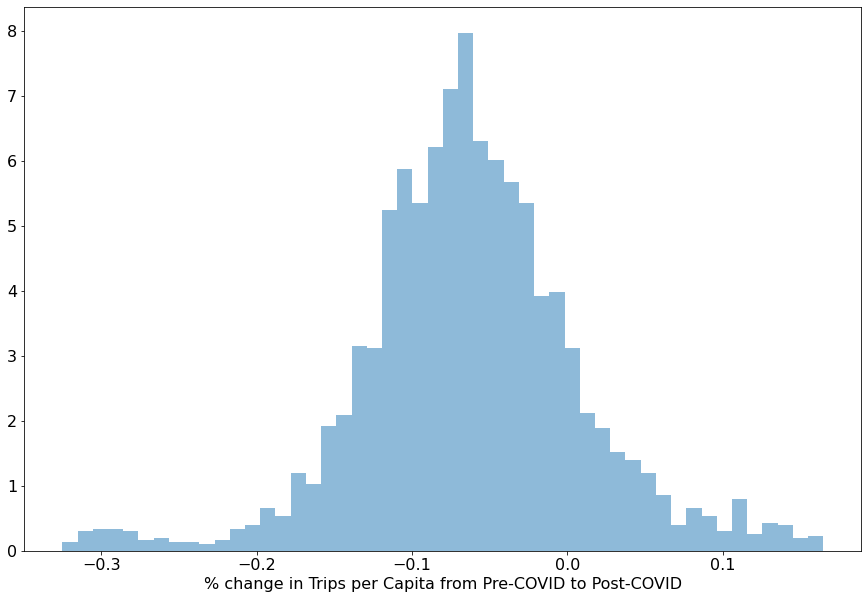

In [48]:
plot_settings = {'alpha': 0.5, 'bins': 50, 'density': True}
df_ = trip_diff_df.drop(trip_diff_df[(trip_diff_df['Post COVID Pct Diff'].isna()) | 
                                     (trip_diff_df['Post COVID Pct Diff'] == np.inf)].index, axis=0)
df_ = df_[df_['Post COVID Pct Diff'] < np.percentile(df_['Post COVID Pct Diff'], 98)]
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(df_['Post COVID Pct Diff'], **plot_settings)
plt.xlabel('% change in Trips per Capita from Pre-COVID to Post-COVID')
plt.savefig('pre_post_trips_per_capita.png')
plt.show();

## Hypothesis 1

Looking at the difference in "trips per capita" by county during the months preceding and following COVID, we can see a general trend towards less trips per capita following COVID lockdowns, which is to be expected. However, there is high variance in the degree to which a county reduced travel during the COVID lockdowns, and some counties see a rise in the number of trips.

My first hypothesis is that urban counties saw the largest decrease in trips per capita compared to suburban and more rural counties. I will be defining urban vs rural counties based on the percentage of a county's population that lives in an urban setting as defined by the Census.

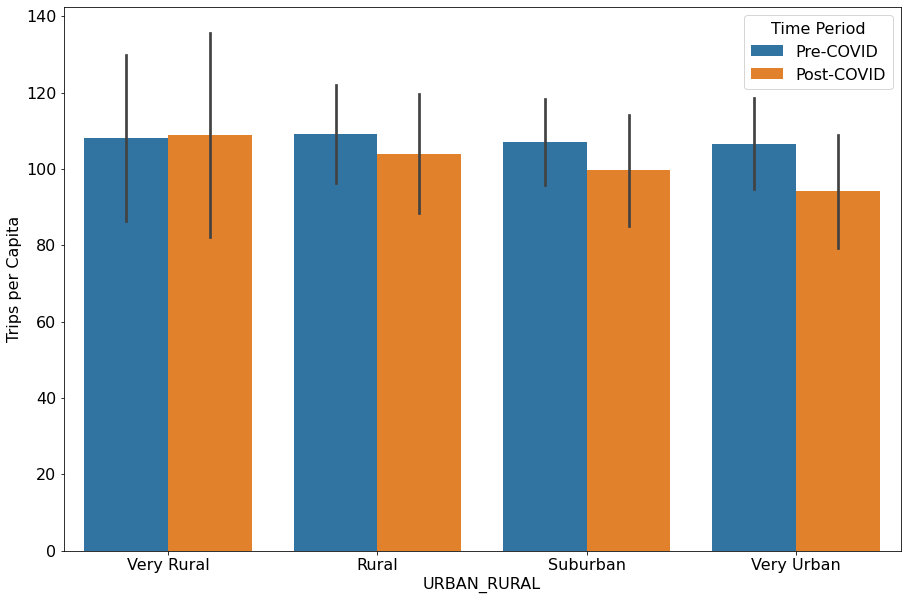

In [49]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=trips_df, x='URBAN_RURAL', y='Trips per Capita', hue='Post_COVID', ci='sd')
plt.legend(bbox_to_anchor=(1.2, 1))
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['Pre-COVID', 'Post-COVID'], title="Time Period")
plt.savefig('pre_post_barplot.png');
### 0 - Pre-COVID
### 1 - Post-COVID

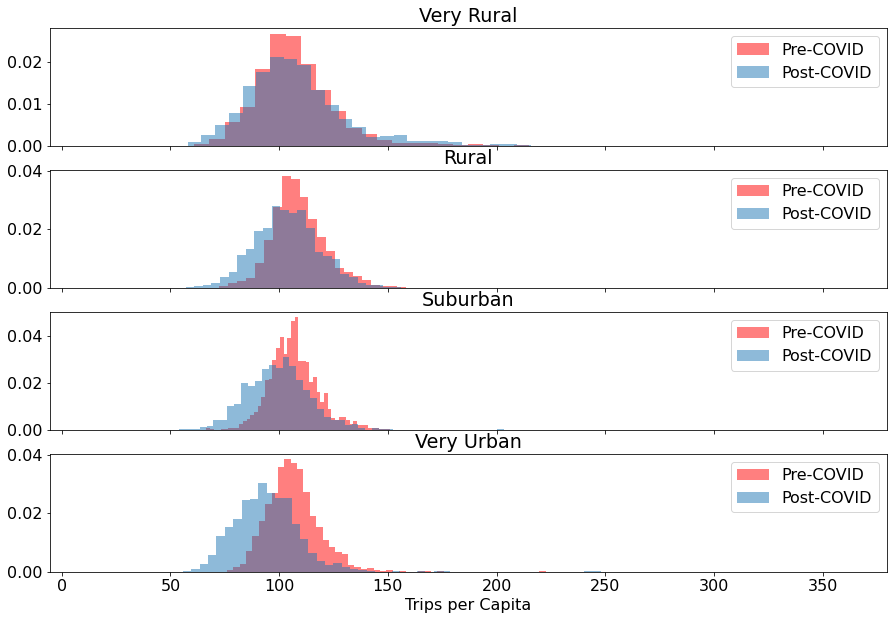

In [50]:
plot_settings = {'alpha': 0.5, 'bins': 50, 'density': True}

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,10), sharex=True)
for ax, ur in zip(axes, ['Very Rural', 'Rural', 'Suburban', 'Very Urban']):
    df_ = trips_df[trips_df['URBAN_RURAL'] == ur]
    ax.hist(df_[df_['Post_COVID'] == 0]['Trips per Capita'], color='r', **plot_settings)
    ax.hist(df_[df_['Post_COVID'] == 1]['Trips per Capita'], **plot_settings)
    ax.legend(['Pre-COVID', 'Post-COVID'])
    ax.set_title(ur)
plt.xlabel('Trips per Capita')
plt.show();

#### What is the actual difference by county?

In [51]:
trip_diff_df = trips_df.groupby(['County FIPS', 'Post_COVID'])[['Trips per Capita']].mean().unstack('Post_COVID').reset_index()
trip_diff_df['Post_COVID_Diff'] = trip_diff_df[('Trips per Capita', 1)] - trip_diff_df[('Trips per Capita', 0)]
trip_diff_df['Post_COVID_Pct_Diff'] = trip_diff_df['Post_COVID_Diff'] / trip_diff_df[('Trips per Capita', 0)]
trip_diff_df.columns = ['County FIPS', 'Pre COVID Trips per Capita', 'Post COVID Trips per Capita', 
                        'Post COVID Diff', 'Post COVID Pct Diff']

In [52]:
trip_diff_df = trip_diff_df.merge(urban_rural_df, on='County FIPS', how='left')

In [53]:
trip_diff_df = trip_diff_df.merge(cc_df, on='County FIPS', how='left')

In [54]:
### Quartiles to describe how urban/rural a county is
trip_diff_df['URBAN_RURAL'] = pd.qcut(trip_diff_df['PCT_URBAN'], q=4, labels=['Very Rural', 'Rural', 'Suburban', 'Very Urban'], duplicates='drop')

In [55]:
trip_diff_df['Senior Percentage'] = trip_diff_df['Senior Population'] / trip_diff_df['Total Population']

In [56]:
trip_diff_df.groupby('URBAN_RURAL')[['Post COVID Diff', 'Post COVID Pct Diff']].mean()

Post COVID Diff  Post COVID Pct Diff
URBAN_RURAL                                      
Very Rural          0.762810             0.004939
Rural              -5.137394            -0.047972
Suburban           -7.134714            -0.066964
Very Urban        -12.300705            -0.116502

In [57]:
trip_diff_df.groupby('URBAN_RURAL')[['Post COVID Diff', 'Post COVID Pct Diff']].skew()

Post COVID Diff  Post COVID Pct Diff
URBAN_RURAL                                      
Very Rural          1.563741             1.438052
Rural               0.415475             0.091342
Suburban           -0.065997            -0.053343
Very Urban          0.122993            -0.619990

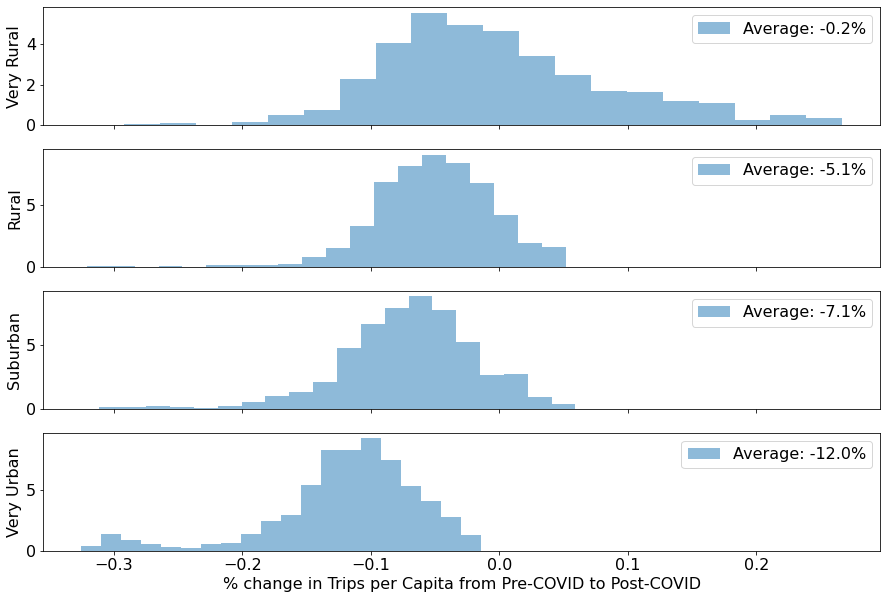

In [58]:
plot_settings = {'alpha': 0.5, 'bins': 20, 'density': True}

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,10), sharex=True)
for ax, ur in zip(axes, ['Very Rural', 'Rural', 'Suburban', 'Very Urban']):
    df_ = trip_diff_df[trip_diff_df['URBAN_RURAL'] == ur]
    df_ = df_.drop(df_[(df_['Post COVID Pct Diff'].isna()) | (df_['Post COVID Pct Diff'] == np.inf)].index, axis=0)
    df_ = df_[df_['Post COVID Pct Diff'] < np.percentile(df_['Post COVID Pct Diff'], 98)]
    ax.hist(df_['Post COVID Pct Diff'], **plot_settings)
    m = np.round(df_['Post COVID Pct Diff'].mean() * 100, 1)
    ax.legend([f'Average: {m}%'])
    ax.set_ylabel(ur)
plt.xlabel('% change in Trips per Capita from Pre-COVID to Post-COVID')
plt.savefig('Urban_Rural_Diff_Hist.png')
plt.show();

In [78]:
trip_diff_df.head()

County FIPS  Pre COVID Trips per Capita  Post COVID Trips per Capita  \
0       01001                  100.901168                    92.455989   
1       01003                   90.927916                    81.678975   
2       01005                  105.707175                   101.443963   
3       01007                  108.893424                   101.800140   
4       01009                  102.161335                    97.741783   

   Post COVID Diff  Post COVID Pct Diff STATENAME COUNTYNAME  PCT_URBAN  \
0        -8.445178            -0.083698   Alabama    Autauga   0.579978   
1        -9.248941            -0.101717   Alabama    Baldwin   0.577209   
2        -4.263213            -0.040330   Alabama    Barbour   0.322104   
3        -7.093284            -0.065140   Alabama       Bibb   0.316474   
4        -4.419552            -0.043261   Alabama     Blount   0.100485   

   PCT_RURAL URBAN_RURAL  Adult Population  Minor Population  \
0   0.420022    Suburban             32982             10593   
1   0.422791    Suburban            121072             39184   
2   0.677896       Rural             14092              4193   
3   0.683526       Rural             13558              3713   
4   0.899515  Very Rural             32417             10935   

   Senior Population  Total Population  Senior Percentage  
0              12294             55869           0.220050  
1              62978            223234           0.282117  
2               6401             24686           0.259297  
3               5123             22394           0.228767  
4              14474             57826           0.250303

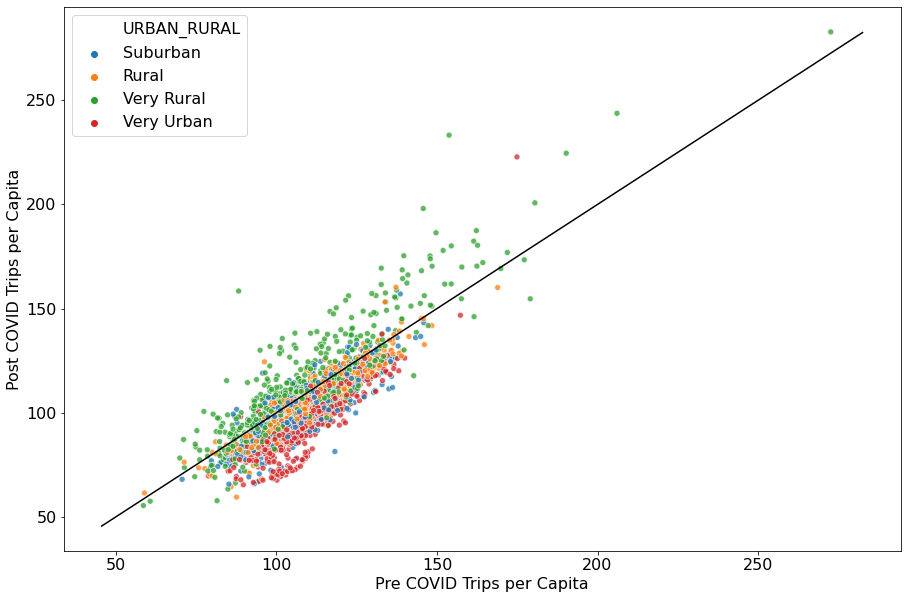

In [87]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x=trip_diff_df['Pre COVID Trips per Capita'], y=trip_diff_df['Post COVID Trips per Capita'], hue=trip_diff_df['URBAN_RURAL'], alpha=0.75)
plt.plot(np.arange(trip_diff_df['Post COVID Trips per Capita'].min(), trip_diff_df['Post COVID Trips per Capita'].max(), 1), np.arange(trip_diff_df['Post COVID Trips per Capita'].min(), trip_diff_df['Post COVID Trips per Capita'].max(), 1), color='black')

#### Hypothesis Test

Formulating a statistical test gives us the following:

$ \mu_{county group} $ : average percent change in trips per capita from pre-COVID to post-COVID months for a given county group.

$ H_0: \mu_{very urban} = \mu_{suburban} $

$ H_a: \mu_{very urban} \neq \mu_{suburban}$

In [59]:
### What is the probability that the differences in these distributions can be seen through random chance? (aka p-value)
### Two sample T-test, Permutation test

county_types = ['Very Urban', 'Suburban', 'Rural', 'Very Rural']

for i in range(len(county_types) - 1):
    for j in range(i + 1, len(county_types)):
        a_label = county_types[i]
        b_label = county_types[j]
        a = trip_diff_df[trip_diff_df['URBAN_RURAL'] == a_label]['Post COVID Pct Diff']
        a = a.drop(a[(a.isna()) | (a == np.inf)].index, axis=0)
        b = trip_diff_df[trip_diff_df['URBAN_RURAL'] == b_label]['Post COVID Pct Diff']
        b = b.drop(b[(b.isna()) | (b == np.inf)].index, axis=0)
        mean_diff = b.mean() - a.mean()
        combined = pd.concat([a, b])
        perm_mean_diff = np.empty(10000)
        ttest, pval = sp.stats.ttest_ind(a, b)
        for k in range(10000):
            perm = np.random.permutation(combined)
            a_ = perm[:len(a)]
            b_ = perm[len(a):]
            m_ = b_.mean() - a_.mean()
            perm_mean_diff[k] = m_
        p_val = len(perm_mean_diff[perm_mean_diff >= mean_diff]) / len(perm_mean_diff)
        print(a_label + ' compared to ' + b_label)
        print('Difference: %.2f' %mean_diff)
        print('Permutation P-value: %.4f' %p_val)
        print('T-test P-value: %.4f\n' %pval)

Very Urban compared to Suburban
Difference: 0.05
Permutation P-value: 0.0000
T-test P-value: 0.0000

Very Urban compared to Rural
Difference: 0.07
Permutation P-value: 0.0000
T-test P-value: 0.0000

Very Urban compared to Very Rural
Difference: 0.12
Permutation P-value: 0.0000
T-test P-value: 0.0000

Suburban compared to Rural
Difference: 0.02
Permutation P-value: 0.0000
T-test P-value: 0.0000

Suburban compared to Very Rural
Difference: 0.07
Permutation P-value: 0.0000
T-test P-value: 0.0000

Rural compared to Very Rural
Difference: 0.05
Permutation P-value: 0.0000
T-test P-value: 0.0000



#### Linear Regression

In [60]:
df_ = trip_diff_df.drop(trip_diff_df[trip_diff_df['Total Population'] <= np.percentile(trip_diff_df['Total Population'], 10)].index, axis=0)
fig = px.scatter(df_, x='PCT_URBAN', y='Post COVID Pct Diff', 
                 hover_data=['STATENAME', 'COUNTYNAME', 'County FIPS', 'Total Population'], trendline='ols')
fig.show()

In [61]:
results = px.get_trendline_results(fig)

results.query('0').iloc[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     921.2
Date:                Thu, 11 Mar 2021   Prob (F-statistic):          2.32e-175
Time:                        20:19:10   Log-Likelihood:                 4024.4
No. Observations:                2825   AIC:                            -8045.
Df Residuals:                    2823   BIC:                            -8033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0185      0.002     -9.314      0.000      -0.022      -0.015
x1            -0.1109      0.004    -30.351      0.000      -0.118      -0.104
==============================================================================
Omnibus:                      212.731   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              982.509
Skew:                          -0.195   Prob(JB):                    4.48e-214
Kurtosis:                       5.863   Cond. No.                         4.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Hypothesis 2

This is driven by the number of small trips (0-5) and medium trips (5-15) that occur in urban counties.

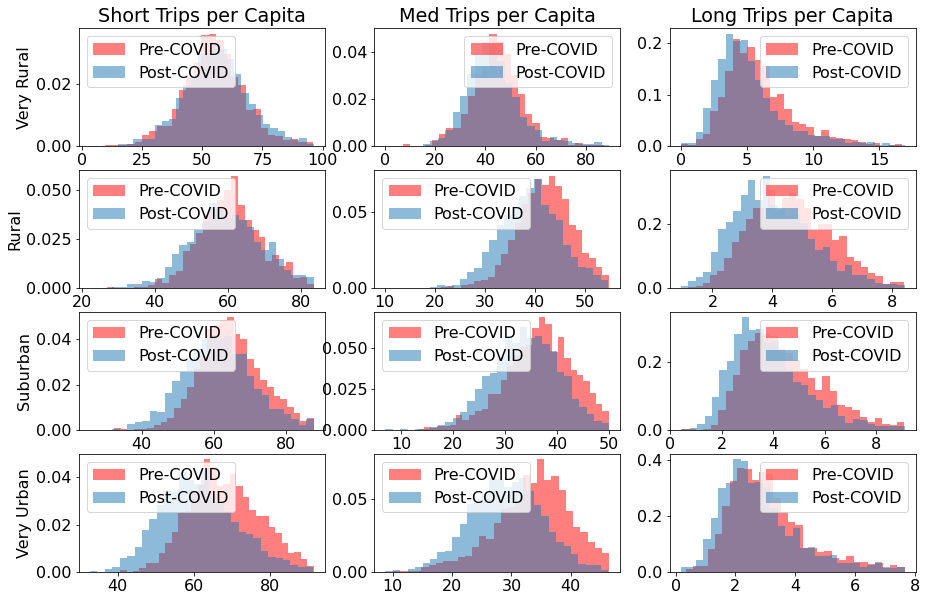

In [62]:
plot_settings = {'alpha': 0.5, 'bins': 30, 'density': True}

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,10))
for ax, ur in zip(axes, ['Very Rural', 'Rural', 'Suburban', 'Very Urban']):
    df_ = trips_df[trips_df['URBAN_RURAL'] == ur]
    for col in ['Short Trips per Capita', 'Med Trips per Capita', 'Long Trips per Capita']:
        df_ = df_.drop(df_[df_[col] >= np.percentile(df_[col], 98)].index, axis=0)
    ax[0].hist(df_[df_['Post_COVID'] == 0]['Short Trips per Capita'], color='r', **plot_settings)
    ax[0].hist(df_[df_['Post_COVID'] == 1]['Short Trips per Capita'], **plot_settings)
    ax[0].legend(['Pre-COVID', 'Post-COVID'])
    
    ax[1].hist(df_[df_['Post_COVID'] == 0]['Med Trips per Capita'], color='r', **plot_settings)
    ax[1].hist(df_[df_['Post_COVID'] == 1]['Med Trips per Capita'], **plot_settings)
    ax[1].legend(['Pre-COVID', 'Post-COVID'])
    
    ax[2].hist(df_[df_['Post_COVID'] == 0]['Long Trips per Capita'], color='r', **plot_settings)
    ax[2].hist(df_[df_['Post_COVID'] == 1]['Long Trips per Capita'], **plot_settings)
    ax[2].legend(['Pre-COVID', 'Post-COVID'])

axes[0,0].set_title('Short Trips per Capita')
axes[0,1].set_title('Med Trips per Capita')
axes[0,2].set_title('Long Trips per Capita')
axes[0,0].set_ylabel('Very Rural')
axes[1,0].set_ylabel('Rural')
axes[2,0].set_ylabel('Suburban')
axes[3,0].set_ylabel('Very Urban')
plt.show();

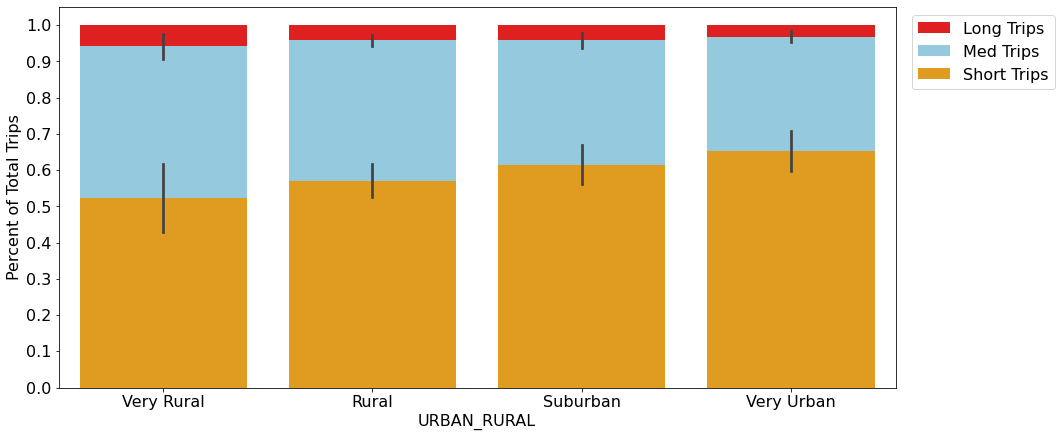

In [63]:
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(data=trips_df, x='URBAN_RURAL', y='Percent Short Med Long', color='r', ci='sd', label='Long Trips')
sns.barplot(data=trips_df, x='URBAN_RURAL', y='Percent Short and Med', color='skyblue', ci='sd', label='Med Trips')
sns.barplot(data=trips_df, x='URBAN_RURAL', y='Percent of Short Trips', color='orange', ci='sd', label='Short Trips')
plt.ylabel('Percent of Total Trips')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.savefig('Urban_Rural_Trip_Breakdown.png', pad_inches=2, bbox_inches='tight');

#### What is the actual difference by county?

In [64]:
trip_len_df = trips_df.groupby(['County FIPS', 'Post_COVID'])[['Short Trips per Capita', 'Med Trips per Capita', 'Long Trips per Capita']].mean().unstack('Post_COVID').reset_index()
trip_len_df['Short_Post_COVID_Diff'] = trip_len_df[('Short Trips per Capita', 1)] - trip_len_df[('Short Trips per Capita', 0)]
trip_len_df['Short Post_COVID_Pct_Diff'] = trip_len_df['Short_Post_COVID_Diff'] / trip_len_df[('Short Trips per Capita', 0)]
trip_len_df['Med_Post_COVID_Diff'] = trip_len_df[('Med Trips per Capita', 1)] - trip_len_df[('Med Trips per Capita', 0)]
trip_len_df['Med Post_COVID_Pct_Diff'] = trip_len_df['Med_Post_COVID_Diff'] / trip_len_df[('Med Trips per Capita', 0)]
trip_len_df['Long_Post_COVID_Diff'] = trip_len_df[('Long Trips per Capita', 1)] - trip_len_df[('Long Trips per Capita', 0)]
trip_len_df['Long Post_COVID_Pct_Diff'] = trip_len_df['Long_Post_COVID_Diff'] / trip_len_df[('Long Trips per Capita', 0)]
trip_len_df.columns = ['County FIPS', 'Pre COVID Short Trips per Capita', 'Post COVID Short Trips per Capita', 
                       'Pre COVID Med Trips per Capita', 'Post COVID Med Trips per Capita', 
                       'Pre COVID Long Trips per Capita', 'Post COVID Long Trips per Capita', 'Short Post COVID Diff', 
                       'Short Post COVID Pct Diff', 'Med Post COVID Diff', 'Med Post COVID Pct Diff', 
                       'Long Post COVID Diff', 'Long Post COVID Pct Diff']

In [65]:
trip_len_df = trip_len_df.merge(urban_rural_df, on='County FIPS', how='left')

In [66]:
trip_len_df = trip_len_df.merge(cc_df, on='County FIPS', how='left')

In [67]:
trip_len_df.groupby('URBAN_RURAL')[['Short Post COVID Diff', 'Short Post COVID Pct Diff', 
                                    'Med Post COVID Diff', 'Med Post COVID Pct Diff', 
                                    'Long Post COVID Diff', 'Long Post COVID Pct Diff']].mean()

Short Post COVID Diff  Short Post COVID Pct Diff  \
URBAN_RURAL                                                     
Very Rural                1.745543                   0.032690   
Rural                    -1.352264                  -0.022525   
Suburban                 -3.836287                  -0.058019   
Very Urban               -7.399223                  -0.106319   

             Med Post COVID Diff  Med Post COVID Pct Diff  \
URBAN_RURAL                                                 
Very Rural             -0.649961                -0.018354   
Rural                  -3.183172                -0.073731   
Suburban               -2.911715                -0.074831   
Very Urban             -4.707734                -0.133291   

             Long Post COVID Diff  Long Post COVID Pct Diff  
URBAN_RURAL                                                  
Very Rural              -0.442321                 -0.100984  
Rural                   -0.652575                 -0.132305  
Suburban                -0.604521                 -0.126447  
Very Urban              -0.383325                 -0.109551

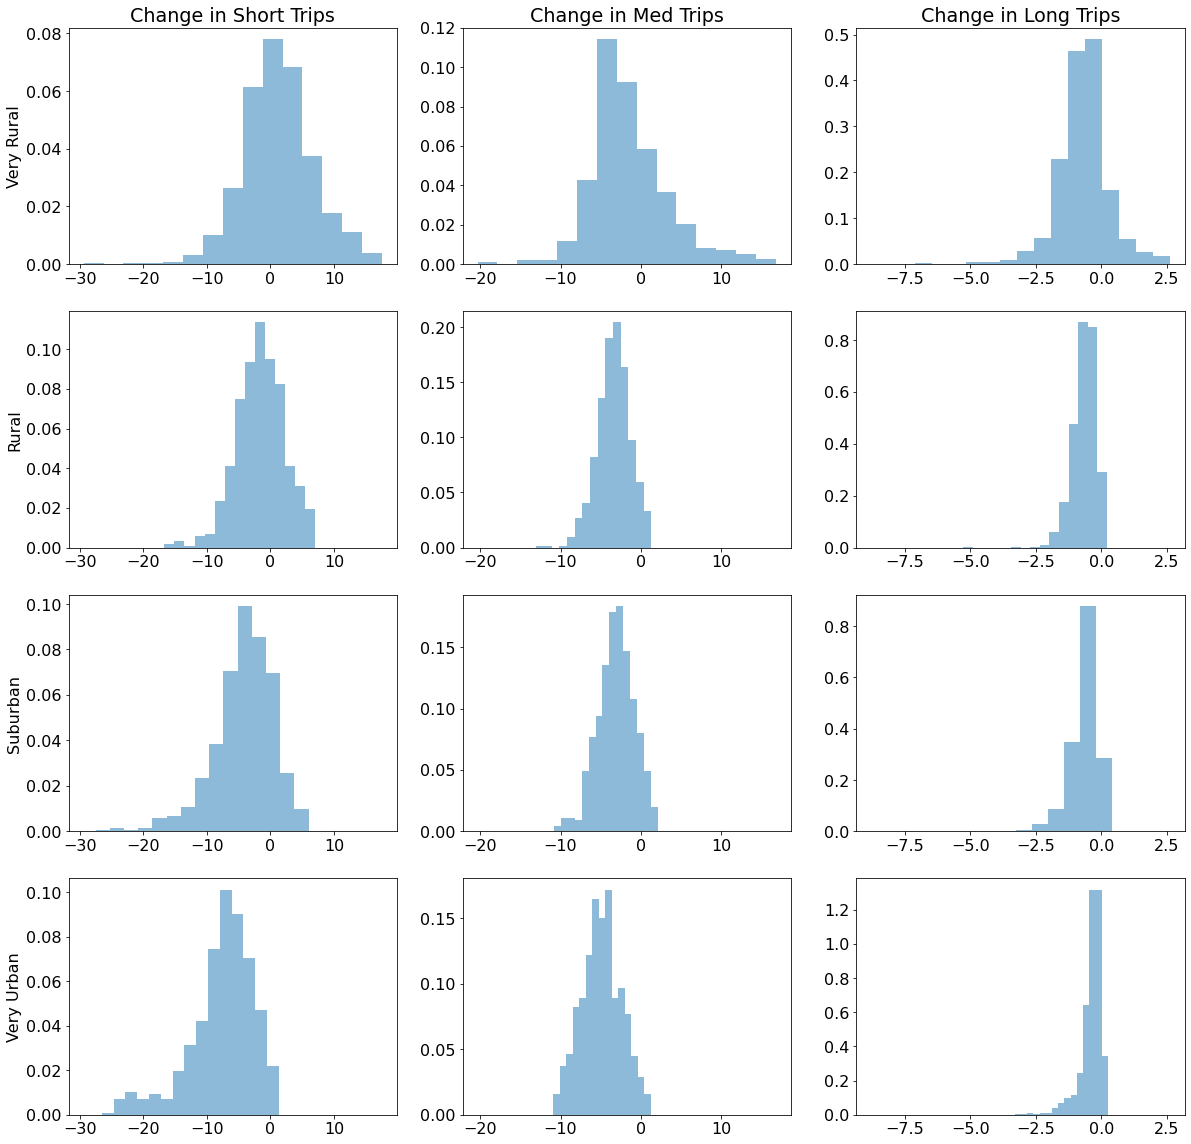

In [68]:
plot_settings = {'alpha': 0.5, 'bins': 15, 'density': True}

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20), sharex='col')
for ax, ur in zip(axes, ['Very Rural', 'Rural', 'Suburban', 'Very Urban']):
    df_ = trip_len_df[trip_len_df['URBAN_RURAL'] == ur]
    for col in ['Short Post COVID Diff', 'Med Post COVID Diff', 'Long Post COVID Diff']:
        df_ = df_.drop(df_[(df_[col].isna()) | (df_[col] == np.inf)].index, axis=0)
        df_ = df_.drop(df_[df_[col] > np.percentile(df_[col], 98)].index, axis=0)
    ax[0].hist(df_['Short Post COVID Diff'], **plot_settings)
    ax[0].xaxis.set_tick_params(labelbottom=True)
    
    ax[1].hist(df_['Med Post COVID Diff'], **plot_settings)
    ax[1].xaxis.set_tick_params(labelbottom=True)
    
    ax[2].hist(df_['Long Post COVID Diff'], **plot_settings)
    ax[2].xaxis.set_tick_params(labelbottom=True)

axes[0,0].set_title('Change in Short Trips')
axes[0,1].set_title('Change in Med Trips')
axes[0,2].set_title('Change in Long Trips')
axes[0,0].set_ylabel('Very Rural')
axes[1,0].set_ylabel('Rural')
axes[2,0].set_ylabel('Suburban')
axes[3,0].set_ylabel('Very Urban')
plt.savefig('Urban_Rural_Trip_Length_Hist.png')
plt.show();

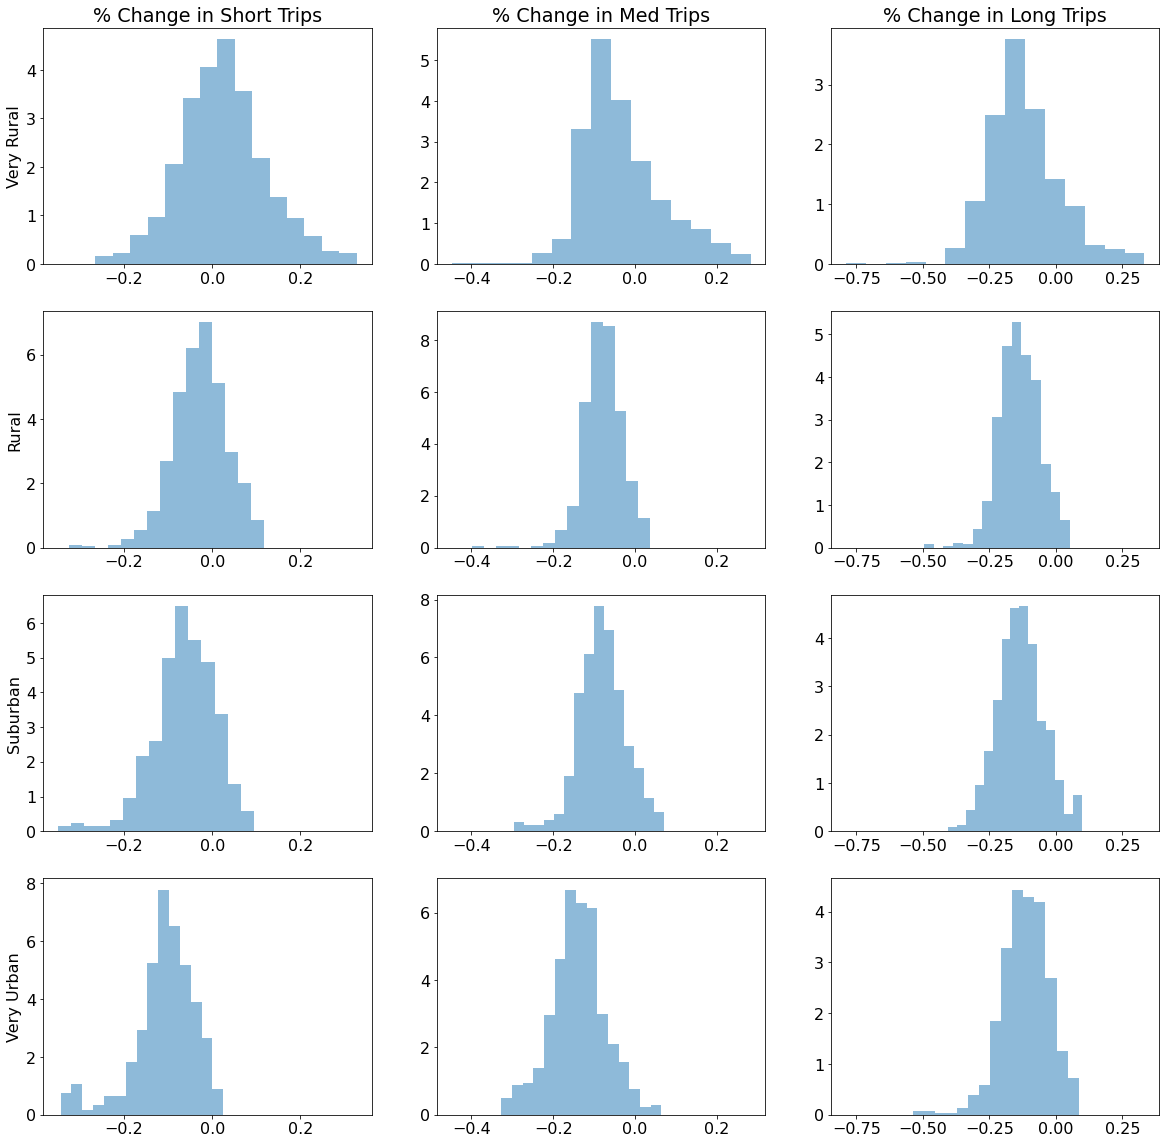

In [69]:
plot_settings = {'alpha': 0.5, 'bins': 15, 'density': True}

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20), sharex='col')
for ax, ur in zip(axes, ['Very Rural', 'Rural', 'Suburban', 'Very Urban']):
    df_ = trip_len_df[trip_len_df['URBAN_RURAL'] == ur]
    for col in ['Short Post COVID Pct Diff', 'Med Post COVID Pct Diff', 'Long Post COVID Pct Diff']:
        df_ = df_.drop(df_[(df_[col].isna()) | (df_[col] == np.inf)].index, axis=0)
        df_ = df_.drop(df_[df_[col] > np.percentile(df_[col], 98)].index, axis=0)
    ax[0].hist(df_['Short Post COVID Pct Diff'], **plot_settings)
    ax[0].xaxis.set_tick_params(labelbottom=True)
    
    ax[1].hist(df_['Med Post COVID Pct Diff'], **plot_settings)
    ax[1].xaxis.set_tick_params(labelbottom=True)
    
    ax[2].hist(df_['Long Post COVID Pct Diff'], **plot_settings)
    ax[2].xaxis.set_tick_params(labelbottom=True)

axes[0,0].set_title('% Change in Short Trips')
axes[0,1].set_title('% Change in Med Trips')
axes[0,2].set_title('% Change in Long Trips')
axes[0,0].set_ylabel('Very Rural')
axes[1,0].set_ylabel('Rural')
axes[2,0].set_ylabel('Suburban')
axes[3,0].set_ylabel('Very Urban')
plt.savefig('Urban_Rural_Trip_Length_Hist.png')
plt.show();

## Some Extra Thoughts

#### Variance by state

State policies contribute to county-by-county variance. California (orange) was among the most strict and earliest to shelter-in-place at a state level. This is reflected in the chart below, which demonstrates that CA counties consistently saw the largest decline in trip activity, regardless of urban status.

In [70]:
df_ = trip_diff_df.drop(trip_diff_df[trip_diff_df['Total Population'] <= np.percentile(trip_diff_df['Total Population'], 10)].index, axis=0)
df_.loc[:, 'CA'] = (df_.loc[:, 'STATENAME'] == 'California').astype(int)

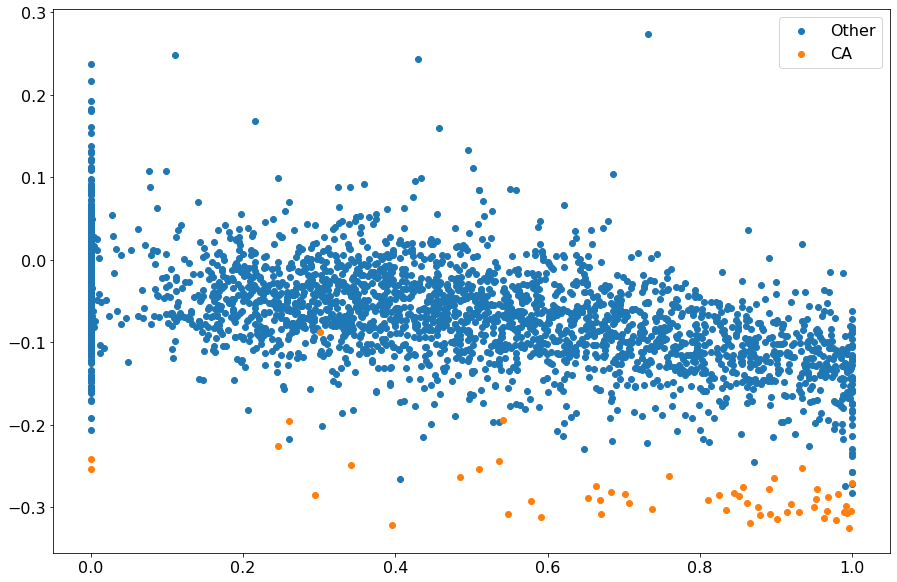

In [71]:
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(data=df_[(df_['CA'] == 0)], x='PCT_URBAN', y='Post COVID Pct Diff')
plt.scatter(data=df_[df_['CA'] == 1], x='PCT_URBAN', y='Post COVID Pct Diff')
plt.legend(['Other', 'CA']);

#### Less trips per person or less people taking trips?

Looking at the average percentage of residents who were not staying at home before and after COVID lockdowns, we can see a general shift towards more people staying at home (particularly in urban settings). However, this does not seem to be as big of a difference as we saw in the number of trips per capita. There is a lot more room to explore here, but it seems like the reduction in trip activity is largely driven by individuals choosing to take less trips than before, as opposed to more residents choosing not to travel at all.

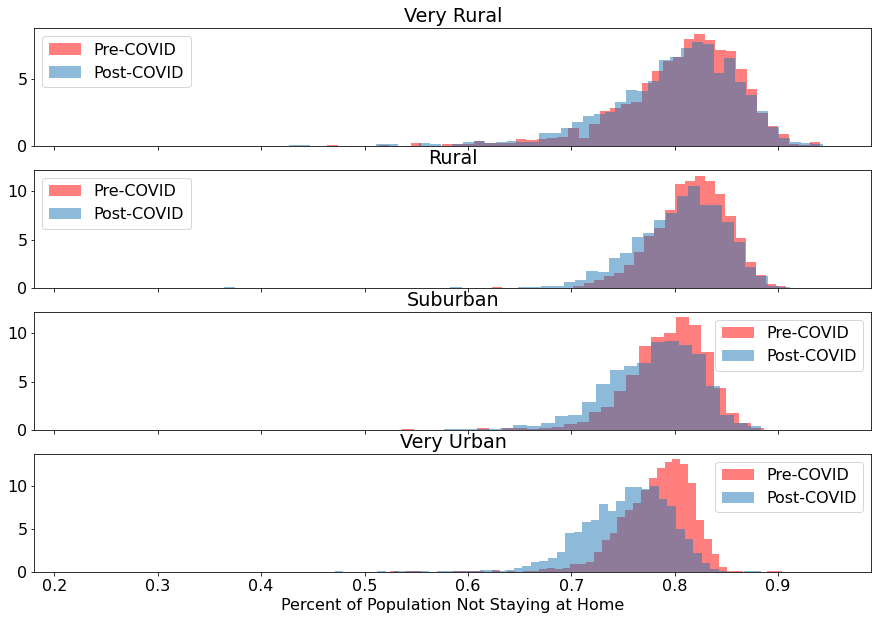

In [72]:
plot_settings = {'alpha': 0.5, 'bins': 50, 'density': True}

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,10), sharex=True)
for ax, ur in zip(axes, ['Very Rural', 'Rural', 'Suburban', 'Very Urban']):
    df_ = trips_df[trips_df['URBAN_RURAL'] == ur]
    ax.hist(df_[df_['Post_COVID'] == 0]['Percent of Population Not Staying at Home'], color='r', **plot_settings)
    ax.hist(df_[df_['Post_COVID'] == 1]['Percent of Population Not Staying at Home'], **plot_settings)
    ax.legend(['Pre-COVID', 'Post-COVID'])
    ax.set_title(ur)
plt.xlabel('Percent of Population Not Staying at Home')
plt.show();

In [73]:
stay_at_home_df = trips_df.groupby(['County FIPS', 'Post_COVID'])['Percent of Population Not Staying at Home'].mean().unstack('Post_COVID').reset_index()

In [74]:
stay_at_home_df['Difference in % of Population Staying at Home'] = stay_at_home_df[1] - stay_at_home_df[0]
stay_at_home_df['% change in Pct_Pop Staying at Home'] = stay_at_home_df['Difference in % of Population Staying at Home'] / stay_at_home_df[0]

In [75]:
stay_at_home_df = stay_at_home_df.merge(urban_rural_df, on='County FIPS', how='left')

In [76]:
stay_at_home_df.groupby('URBAN_RURAL')['Difference in % of Population Staying at Home'].mean()

URBAN_RURAL
Very Rural   -0.007186
Rural        -0.010013
Suburban     -0.014392
Very Urban   -0.029719
Name: Difference in % of Population Staying at Home, dtype: float64

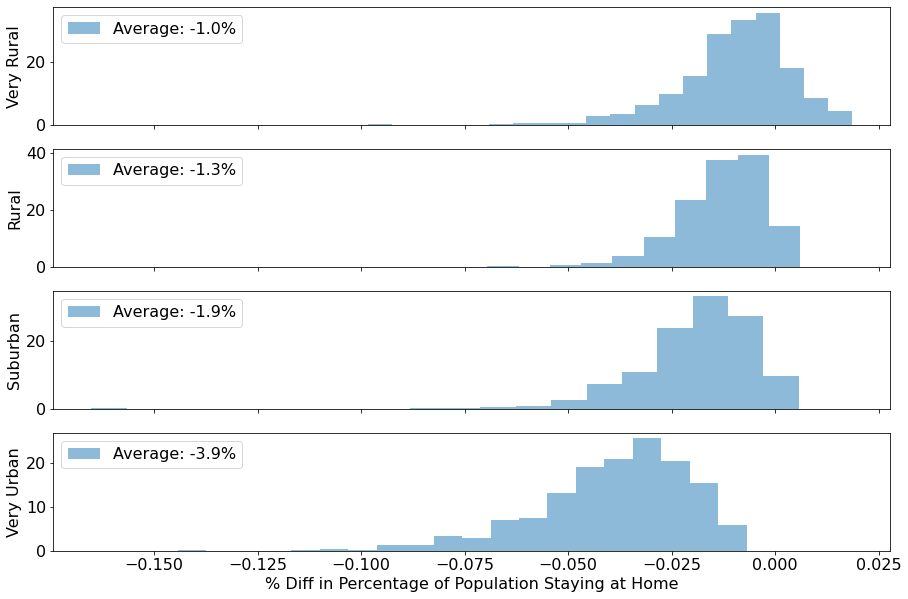

In [77]:
plot_settings = {'alpha': 0.5, 'bins': 20, 'density': True}

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,10), sharex=True)
for ax, ur in zip(axes, ['Very Rural', 'Rural', 'Suburban', 'Very Urban']):
    df_ = stay_at_home_df[stay_at_home_df['URBAN_RURAL'] == ur]
    df_ = df_.drop(df_[(df_['% change in Pct_Pop Staying at Home'].isna()) | (df_['% change in Pct_Pop Staying at Home'] == np.inf)].index, axis=0)
    df_ = df_[df_['% change in Pct_Pop Staying at Home'] < np.percentile(df_['% change in Pct_Pop Staying at Home'], 98)]
    ax.hist(df_['% change in Pct_Pop Staying at Home'], **plot_settings)
    m = np.round(df_['% change in Pct_Pop Staying at Home'].mean() * 100, 1)
    ax.legend([f'Average: {m}%'], loc='upper left')
    ax.set_ylabel(ur)
plt.xlabel('% Diff in Percentage of Population Staying at Home')
plt.show();